## IMPORTING LIBRARIES


In [168]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import jinja2
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)



In [169]:
#Loading the dataset
data = pd.read_csv("/Users/artashesmatshkalyan/Python Projects/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## DATA CLEANING AND PREPARATION

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [171]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points:", len(data))

The total number of data-points: 2216


In [172]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [173]:
#Creating a feature ("Customer_For") of the number of days the customers 
#started to shop in the store relative to the last recorded date

days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [174]:
#Now we will be exploring the unique values in the categorical features to get a clear idea of the data.

marital_status_counts = data["Marital_Status"].value_counts()
education_counts = data["Education"].value_counts()

# Creating DataFrame from the value counts
marital_status_df = pd.DataFrame(marital_status_counts).reset_index()
education_df = pd.DataFrame(education_counts).reset_index()

# Renaming columns for clarity
marital_status_df.columns = ['Marital_Status', 'Count']
education_df.columns = ['Education', 'Count']

# Applying conditional formatting to the tables
marital_status_formatted = (marital_status_df.style
                            .background_gradient(cmap='viridis', subset=['Count'])
                            .set_caption('Marital Status Counts'))

education_formatted = (education_df.style
                       .background_gradient(cmap='viridis', subset=['Count'])
                       .set_caption('Education Counts'))

# Displaying the formatted tables
display(marital_status_formatted)
display(education_formatted)


,Marital_Status,Count
0,Married,857
1,Together,573
2,Single,471
3,Divorced,232
4,Widow,76
5,Alone,3
6,Absurd,2
7,YOLO,2


,Education,Count
0,Graduation,1116
1,PhD,481
2,Master,365
3,2n Cycle,200
4,Basic,54


In [175]:
#Updating dataframe with new columns adn dimentions
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [176]:
#Let's check the main statistics of the dataset
data.describe()


,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x800 with 0 Axes>

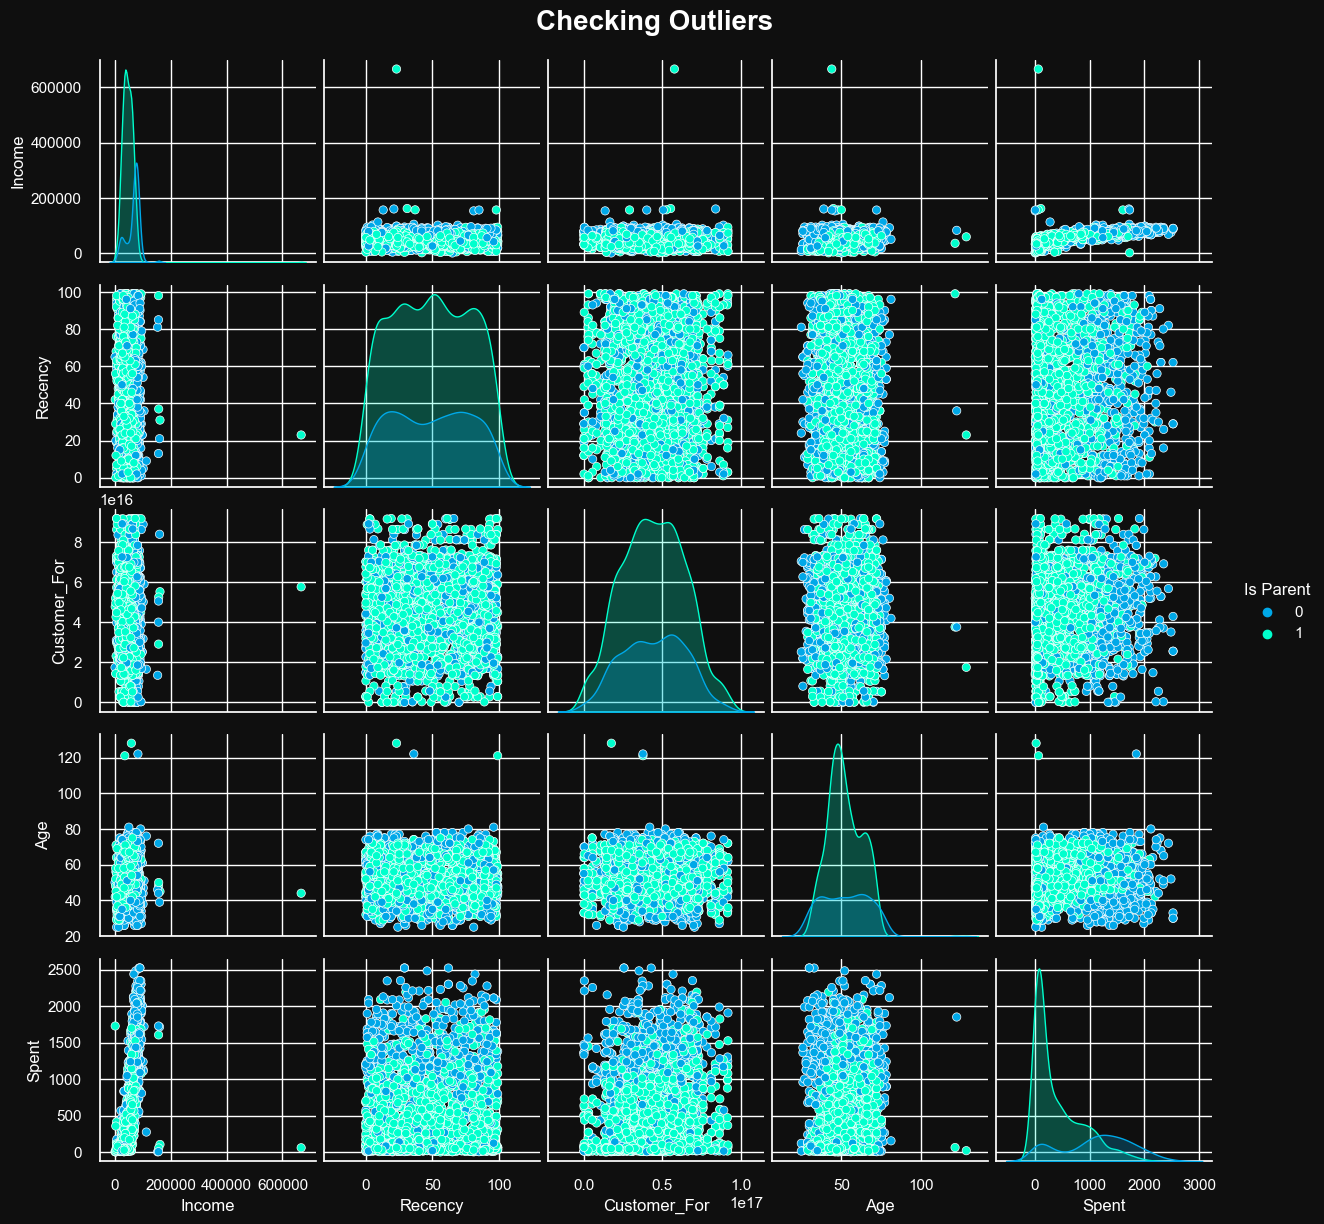

In [177]:
# To plot some selected features 
# Setting up colors preferences
sns.set(rc={"axes.facecolor": "#0F0F0F", "figure.facecolor": "#0F0F0F", 
            "axes.labelcolor": "white", 'xtick.color': 'white', 'ytick.color': 'white'})
pallet = ["#00A8E8", "#FFD300", "#FF8700", "#FF0000", "#8C00FF", "#00FFCD"]
cmap = colors.ListedColormap(["#00A8E8", "#FFD300", "#FF8700", "#FF0000", "#8C00FF", "#00FFCD"])
# Plotting following features
To_Plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure(figsize=(8, 8))  # Adjust the size here (width, height)
plot = sns.pairplot(data[To_Plot], hue="Is_Parent", palette=(["#00A8E8", "#00FFCD"]), height=2.5)
# Taking hue 
plt.setp(plot._legend.get_texts(), color='white')  # Set legend text color to white
plot._legend.set_title("Is Parent")
plt.setp(plot._legend.get_title(), color='white')  # Set legend title color to white
plt.suptitle("Checking Outliers", fontsize=20, fontweight='bold', color='white')  # Add the title
plt.subplots_adjust(top=0.94)  # Add additional space for the title
plt.show()

In [178]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


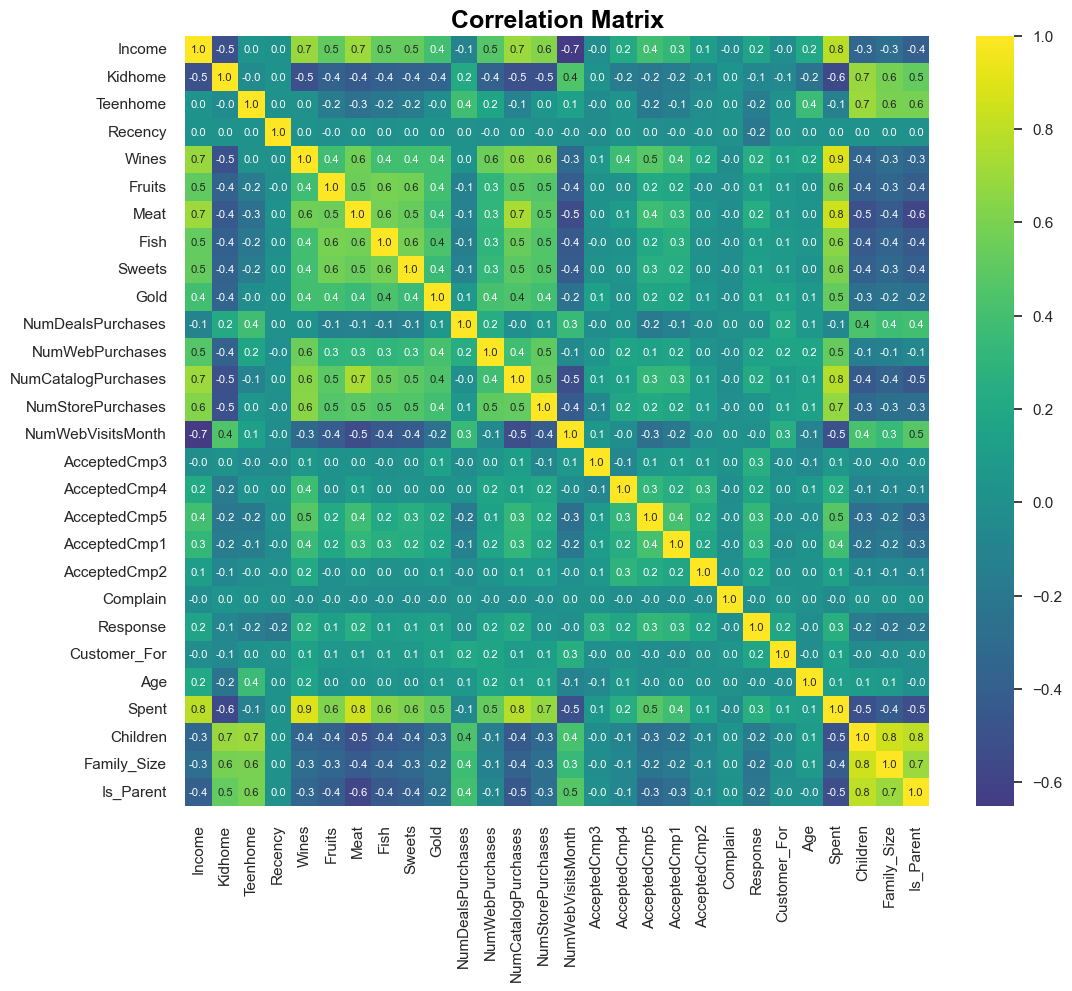

In [179]:
# Set modern styling
sns.set_style("whitegrid")

# Create correlation matrix
corrmat = data.corr()

# Set figure size
plt.figure(figsize=(12, 10))

# Plot heatmap with smaller font size and modern colors
sns.heatmap(corrmat, annot=True, cmap='viridis', center=0, fmt=".1f", annot_kws={"size": 8})  # Adjust annot_kws to change font size

# Add title
plt.title('Correlation Matrix', fontsize=18, fontweight='bold', color='black')

# Show plot
plt.show()

### DATA PREPROCESSING

#### We preprocess the data by performing the following steps:

- Transforming categorical features into numerical labels through label encoding.
- Standardizing the features using the standard scaler.
- Generating a smaller subset of the dataframe to reduce dimensionality."

In [180]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [181]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [182]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [183]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


### DIMENSIONALITY REDUCTION
### Principal component analysis (PCA) is utilized to decrease the dimensionality of complex datasets, enhancing interpretability while minimizing loss of information.

- Steps in this section:

1. Employing PCA for dimensionality reduction.
2. Visualizing the reduced dataframe.
3. Dimensionality reduction with PCA.
#### In this project, the dimensions will be reduced to 3.



In [184]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-1.290910e-16,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,-5.521001e-17,1.706839,-4.312196,-1.328316,-0.158123,1.242289,6.142721
col3,2212.0,6.853569e-17,1.221956,-3.530416,-0.829067,-0.022692,0.799895,6.611222


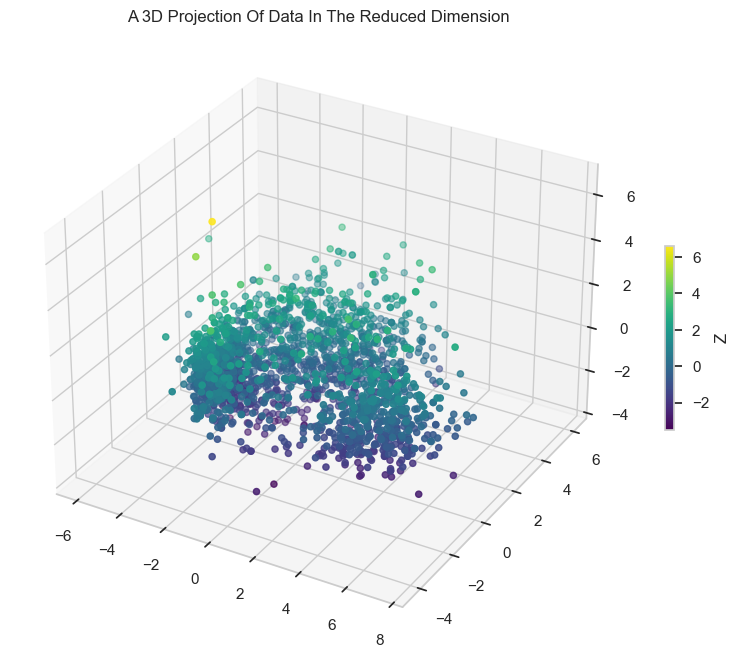

In [185]:

# Assuming you already have x, y, and z variables from PCA_ds DataFrame

# Define a modern colormap
cmap = 'viridis'  # You can choose any other colormap from Matplotlib

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(x, y, z, c=z, cmap=cmap, marker="o")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")

# Add colorbar with adjusted height
cbar = plt.colorbar(sc, ax=ax, label='Z', shrink=0.3)  # Adjust the shrink parameter to decrease the height of the colorbar

plt.show()


###  CLUSTERING
#### The clustering process includes:

- Utilizing the Elbow Method to identify the optimal number of clusters.
- Conducting clustering using Agglomerative Clustering.
- Analyzing the clusters formed through a scatter plot.

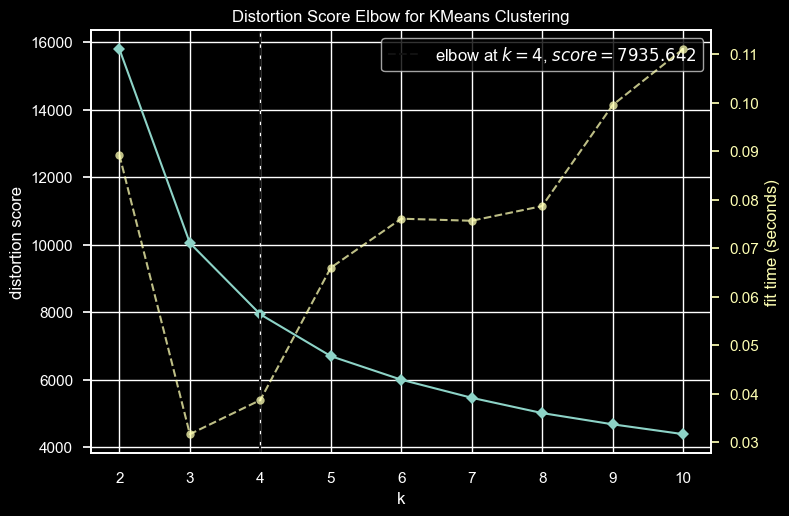

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [208]:
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Set dark mode style
plt.style.use('dark_background')

# Initialize the KElbowVisualizer with KMeans model
Elbow_M = KElbowVisualizer(KMeans(), k=10)

# Fit the visualizer to the data
Elbow_M.fit(PCA_ds)

# Customize line colors and styles
Elbow_M.finalize()
Elbow_M.ax.spines['bottom'].set_color('white')
Elbow_M.ax.spines['top'].set_color('white')
Elbow_M.ax.spines['right'].set_color('white')
Elbow_M.ax.spines['left'].set_color('white')
Elbow_M.ax.xaxis.label.set_color('white')
Elbow_M.ax.yaxis.label.set_color('white')
Elbow_M.ax.tick_params(axis='x', colors='white')
Elbow_M.ax.tick_params(axis='y', colors='white')

# Choose a modern color palette for line colors
modern_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
Elbow_M.colors_ = modern_colors

# Show the plot
Elbow_M.show()


#### The preceding section suggests that four clusters will be optimal for this dataset. Following this, we'll proceed to apply the Agglomerative Clustering Model to determine the final clusters.

In [188]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC


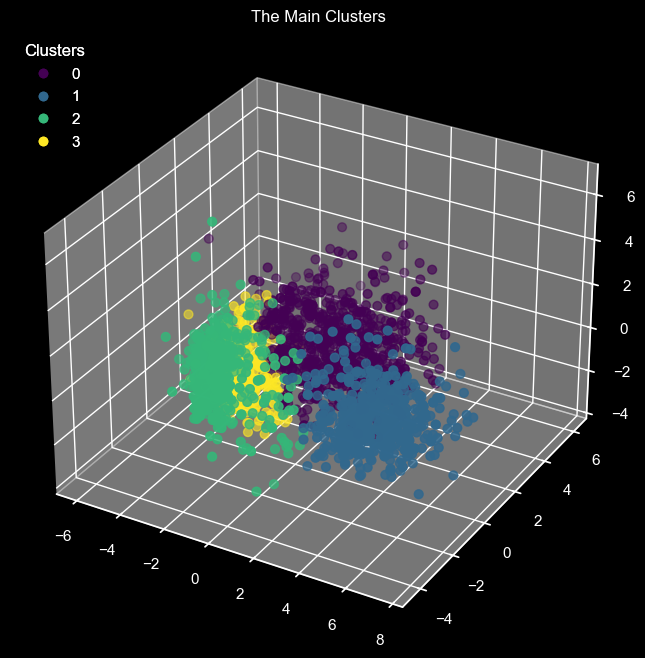

In [189]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming cmap is defined somewhere in your code
cmap = plt.get_cmap('viridis')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming x, y, z, and PCA_ds["Clusters"] are defined somewhere in your code
sc = ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)

# Creating a legend for the clusters
legend1 = ax.legend(*sc.legend_elements(), title="Clusters", loc="upper left")
ax.add_artist(legend1)

# Adding title to the plot
plt.title("The Main Clusters", color='white')

# Show the plot
plt.show()


### EVALUATING MODELS



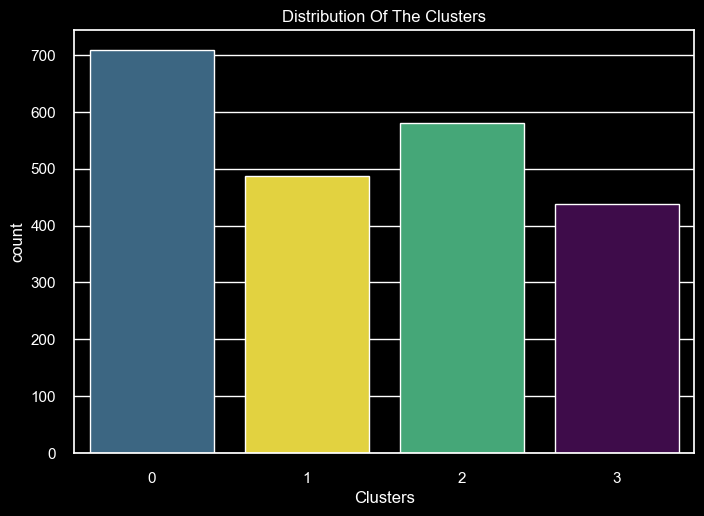

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the 3D scatter plot first and obtain the scatter object
# Assuming cmap is defined somewhere in your code
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming x, y, z, and PCA_ds["Clusters"] are defined somewhere in your code
sc = ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)

# Extract the colors used in the scatter plot
scatter_colors = [sc.cmap(sc.norm(cluster)) for cluster in PCA_ds["Clusters"].unique()]

# Close the scatter plot to prevent it from being displayed
plt.close(fig)

# Use the extracted colors for the bar plot
pl = sns.countplot(x=data["Clusters"], palette=scatter_colors)
pl.set_title("Distribution Of The Clusters")
plt.show()


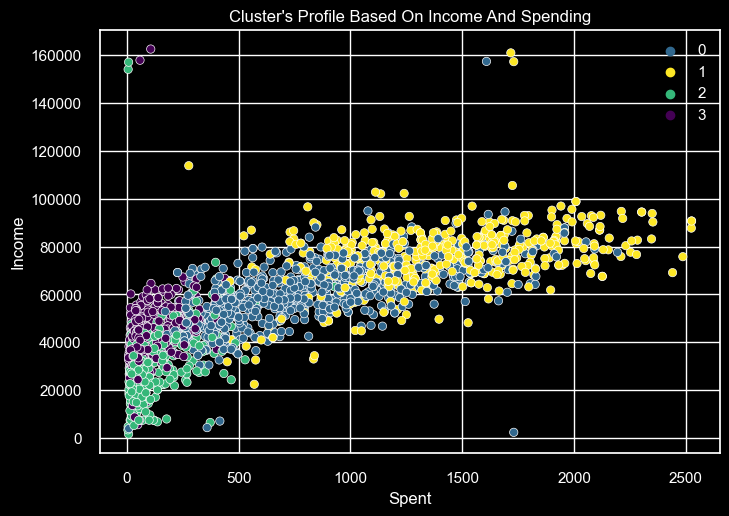

In [198]:
# Create the 3D scatter plot first and obtain the scatter object
# Assuming cmap is defined somewhere in your code
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming x, y, z, and PCA_ds["Clusters"] are defined somewhere in your code
sc = ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)

# Extract the colors used in the scatter plot
scatter_colors = [sc.cmap(sc.norm(cluster)) for cluster in PCA_ds["Clusters"].unique()]

# Close the scatter plot to prevent it from being displayed
plt.close(fig)

# Use the extracted colors for the scatter plot of income versus spending
pl = sns.scatterplot(data=data, x=data["Spent"], y=data["Income"], hue=data["Clusters"], palette=scatter_colors)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

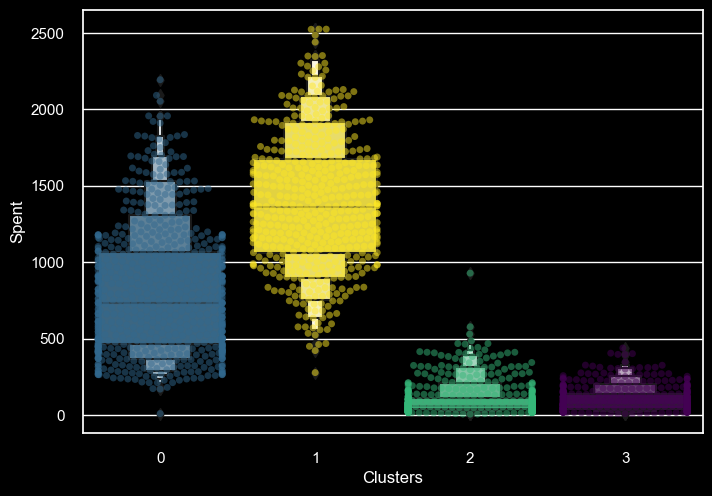

In [200]:
# Create the 3D scatter plot first and obtain the scatter object
# Assuming cmap is defined somewhere in your code
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming x, y, z, and PCA_ds["Clusters"] are defined somewhere in your code
sc = ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)

# Extract the colors used in the scatter plot
scatter_colors = [sc.cmap(sc.norm(cluster)) for cluster in PCA_ds["Clusters"].unique()]

# Close the scatter plot to prevent it from being displayed
plt.close(fig)

# Use the extracted colors for the swarm plot and boxen plot
plt.figure()
pl = sns.swarmplot(x=data["Clusters"], y=data["Spent"], palette=scatter_colors, alpha=0.5)
pl = sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=scatter_colors)
plt.show()

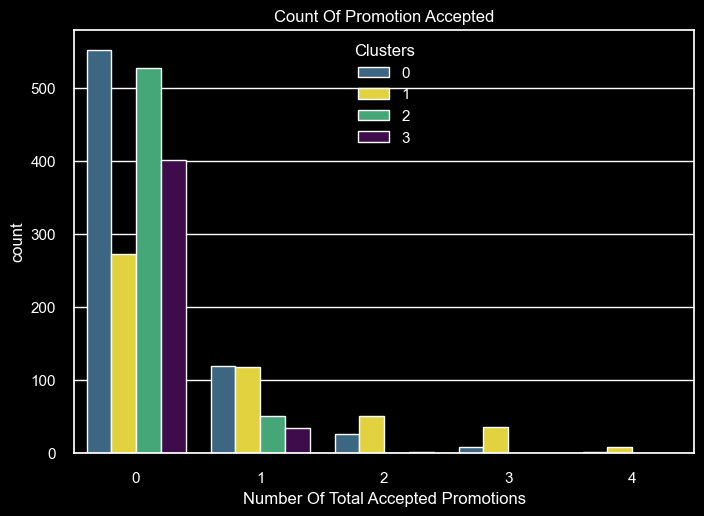

In [202]:
# Create the 3D scatter plot first and obtain the scatter object
# Assuming cmap is defined somewhere in your code
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming x, y, z, and PCA_ds["Clusters"] are defined somewhere in your code
sc = ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)

# Extract the colors used in the scatter plot
scatter_colors = [sc.cmap(sc.norm(cluster)) for cluster in PCA_ds["Clusters"].unique()]

# Close the scatter plot to prevent it from being displayed
plt.close(fig)

# Use the extracted colors for the countplot of total campaign accepted
plt.figure()
pl = sns.countplot(x=data["Total_Promos"], hue=data["Clusters"], palette=scatter_colors)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

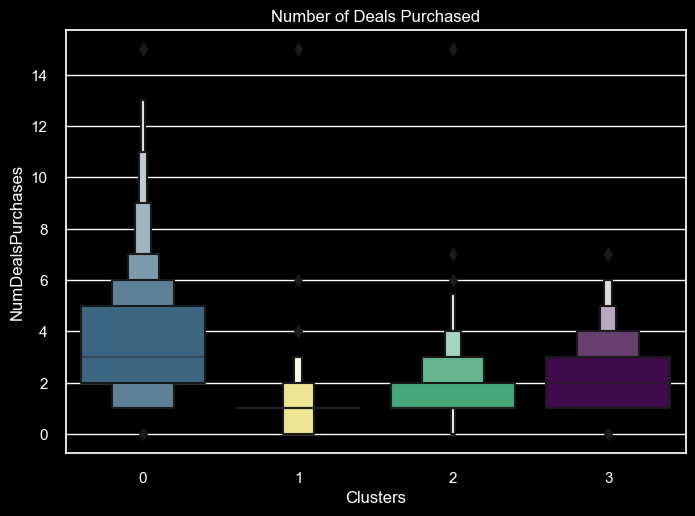

In [203]:
# Create the 3D scatter plot first and obtain the scatter object
# Assuming cmap is defined somewhere in your code
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming x, y, z, and PCA_ds["Clusters"] are defined somewhere in your code
sc = ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)

# Extract the colors used in the scatter plot
scatter_colors = [sc.cmap(sc.norm(cluster)) for cluster in PCA_ds["Clusters"].unique()]

# Close the scatter plot to prevent it from being displayed
plt.close(fig)

# Use the extracted colors for the boxen plot of the number of deals purchased
plt.figure()
pl = sns.boxenplot(y=data["NumDealsPurchases"], x=data["Clusters"], palette=scatter_colors)
pl.set_title("Number of Deals Purchased")
plt.show()

<Figure size 800x550 with 0 Axes>

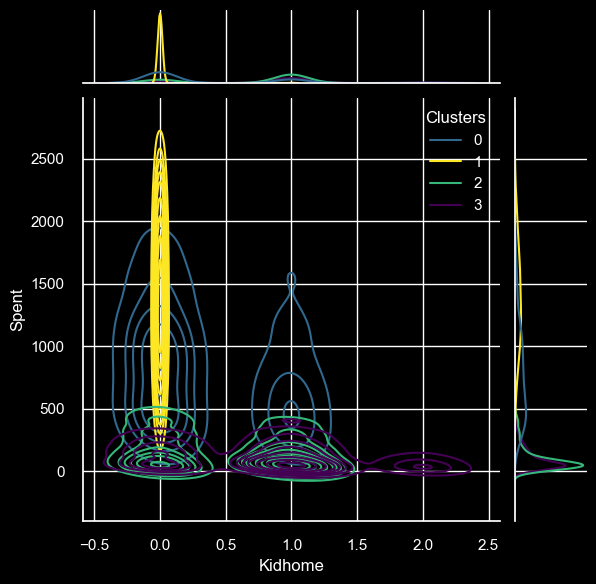

<Figure size 800x550 with 0 Axes>

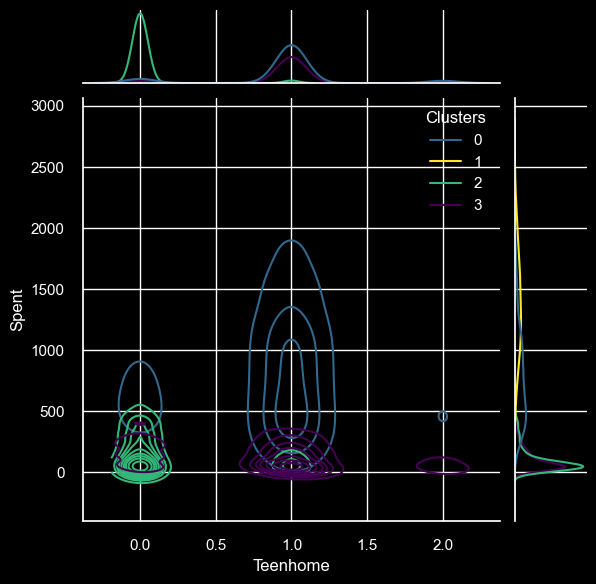

<Figure size 800x550 with 0 Axes>

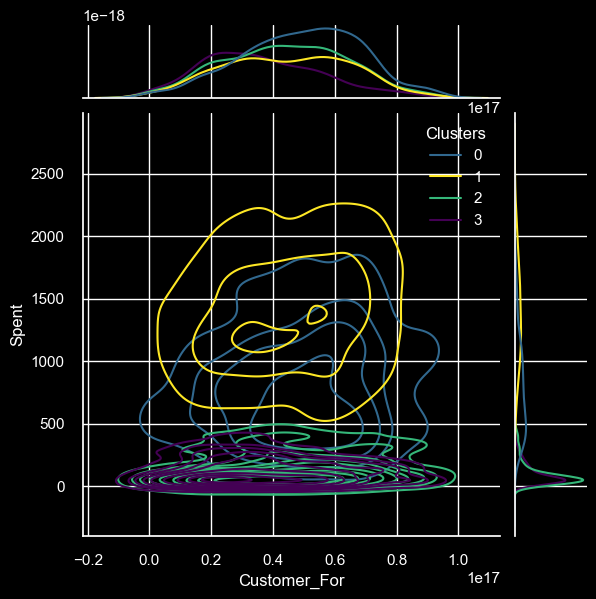

<Figure size 800x550 with 0 Axes>

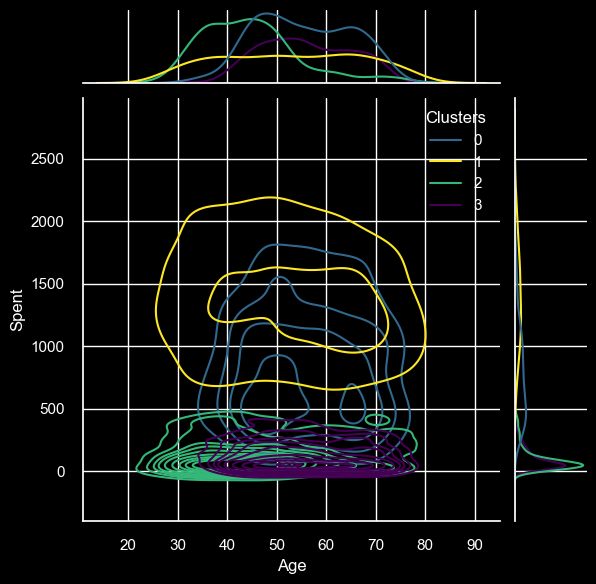

<Figure size 800x550 with 0 Axes>

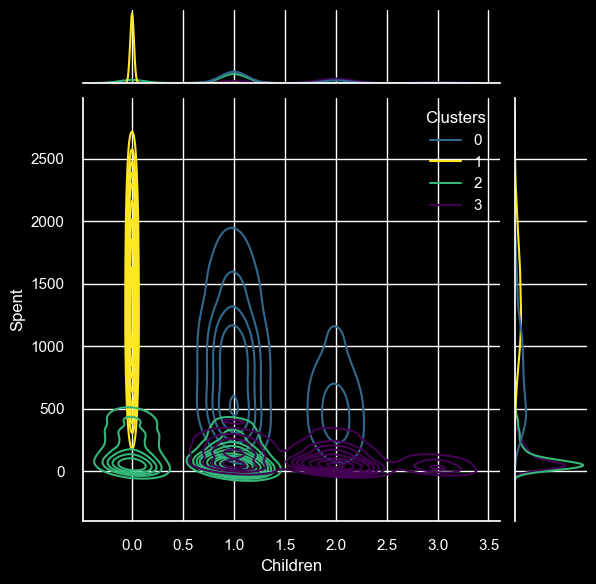

<Figure size 800x550 with 0 Axes>

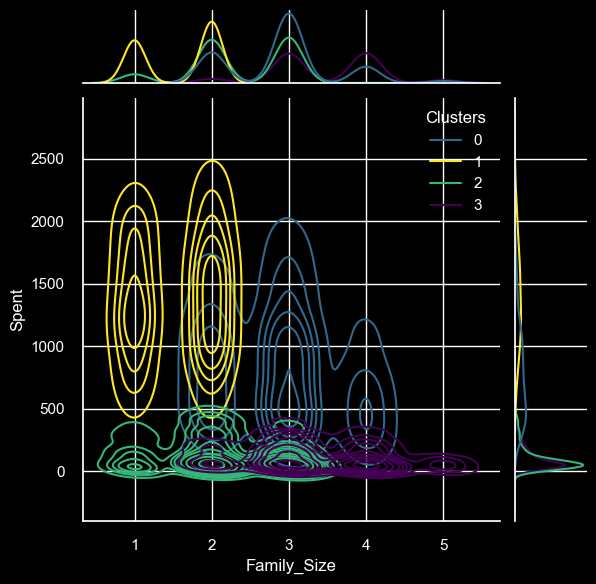

<Figure size 800x550 with 0 Axes>

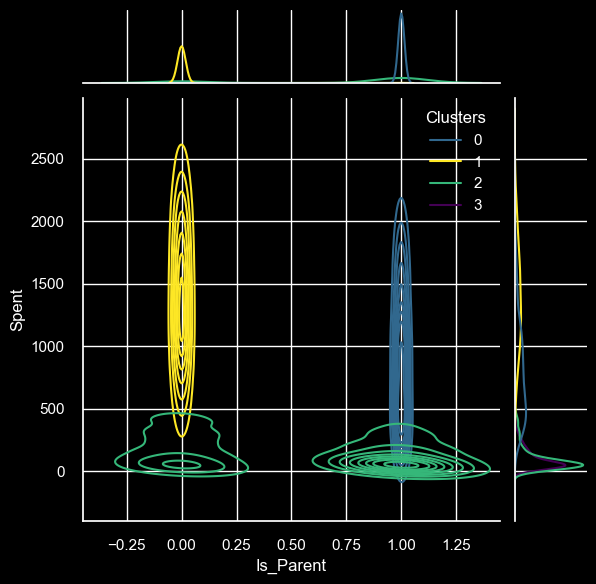

<Figure size 800x550 with 0 Axes>

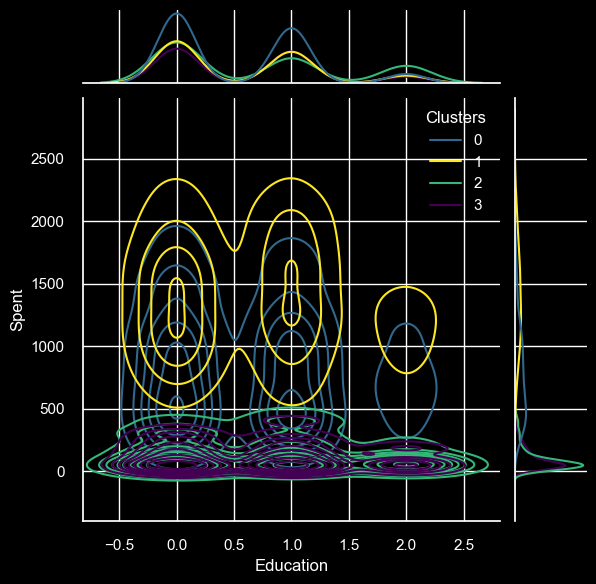

<Figure size 800x550 with 0 Axes>

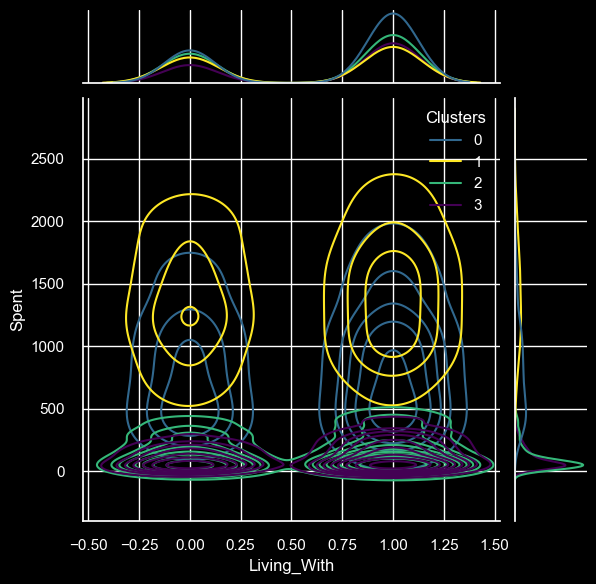

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the 3D scatter plot first and obtain the scatter object
# Assuming cmap is defined somewhere in your code
cmap = plt.get_cmap('viridis')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming x, y, z, and PCA_ds["Clusters"] are defined somewhere in your code
sc = ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)

# Extract the colors used in the scatter plot
scatter_colors = [sc.cmap(sc.norm(cluster)) for cluster in PCA_ds["Clusters"].unique()]

# Close the scatter plot to prevent it from being displayed
plt.close(fig)

# Use the extracted colors for the joint plots
Personal = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]
for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue=data["Clusters"], kind="kde", palette=scatter_colors)
    plt.show()


### The provided details offer insights into the characteristics of customers across various clusters.
Cluster 0:

- Likely parents with 2 to 4 family members, including single parents.
- Mostly have teenagers at home.
- Generally older in age.

Cluster 1:

- Not parents.
- Typically 2 members in the family, mostly couples.
- Represent various age groups.
-High income earners.

Cluster 2:

- Mostly parents.
- Families usually consist of 3 members with one child (not teenagers).
- Generally younger.

Cluster 3:

- Definitely parents.
- Families range from 2 to 5 members.
- Majority have teenagers at home.
- Older in age and lower-income group.


